In [1]:
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import numpy as np
import torch
import cv2

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


In [2]:
SRC_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/images")          # raw images
SAM_CKPT = Path("sam/sam_vit_l_0b3195.pth")                             # downloaded weight
DEVICE   = "cuda:0" if torch.cuda.is_available() else "cpu"
MODEL_TYPE = "vit_l"   # 'vit_h' or 'vit_b' also work (H needs >18 GB VRAM)

# Skip extremely small thumbnails (after crop they become useless)
MIN_SIDE_AFTER_CROP = 128   # pixels – set None to keep everything

# Optional JPEG quality for saved crops (higher = bigger files)
JPEG_QUALITY = 95

In [3]:
# %%
sam = sam_model_registry[MODEL_TYPE](checkpoint=str(SAM_CKPT))
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
)
print("Loaded SAM (", MODEL_TYPE, ") on", DEVICE)


/home/user1/.local/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Loaded SAM ( vit_l ) on cuda:0


In [4]:
def crop_with_mask(pil_img: Image.Image, mask: np.ndarray, pad_px: int = 0) -> Image.Image:
    """Return the cropped RGB PIL image given a binary mask (True = fg)."""
    if mask.sum() == 0:  # empty mask – return original
        return pil_img

    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    # add padding but keep inside bounds
    y0 = max(0, y0 - pad_px)
    x0 = max(0, x0 - pad_px)
    y1 = min(pil_img.height, y1 + pad_px)
    x1 = min(pil_img.width,  x1 + pad_px)

    return pil_img.crop((x0, y0, x1, y1))


In [5]:
# Get image paths and sort by object_id
img_paths = list(SRC_DIR.rglob("*.jpg")) + list(SRC_DIR.rglob("*.jpeg"))

# Extract object_id directly from filename (before first underscore)
def get_object_id_from_filename(path):
    filename = path.stem  # filename without extension
    try:
        # Extract number before first underscore
        object_id = int(filename.split('_')[0])
        return object_id
    except (ValueError, IndexError):
        return 999999  # fallback for invalid filenames

img_paths = sorted(img_paths, key=get_object_id_from_filename)
print(f"➜Processing {len(img_paths):,} images for inscribed square cropping (sorted by object_id)")

# Print first few to verify sorting
for i, path in enumerate(img_paths[:10]):
    obj_id = get_object_id_from_filename(path)
    print(f"  {i+1:2d}. Object ID: {obj_id:5d} - {path.name}")

➜Processing 18,645 images for inscribed square cropping (sorted by object_id)
   1. Object ID: 13561 - 13561_Bed_hanging_blue-resist_textile_primary.jpg
   2. Object ID: 13562 - 13562_Bed_hanging_blue-resist_textile_primary.jpg
   3. Object ID: 13735 - 13735_Panel_blue-resist_textile_primary.jpg
   4. Object ID: 13737 - 13737_Embroidered_Picture_primary.jpg
   5. Object ID: 13740 - 13740_Embroidered_picture_of_Charles_I_primary.jpg
   6. Object ID: 13794 - 13794_Valance_blue-resist_textile_primary.jpg
   7. Object ID: 13795 - 13795_Partial_curtain_blue-resist_textile_primary.jpg
   8. Object ID: 13796 - 13796_Piece_blue-resist_textile_primary.jpg
   9. Object ID: 13798 - 13798_Piece_blue-resist_textile_primary.jpg
  10. Object ID: 13799 - 13799_Panel_blue-resist_textile_primary.jpg


In [6]:
def get_most_central_mask(masks, img_shape):
    """Select the mask whose center is closest to the image center."""
    if len(masks) == 0:
        return None
    
    img_center_y, img_center_x = img_shape[0] // 2, img_shape[1] // 2
    
    best_mask = None
    min_distance = float('inf')
    
    for mask_data in masks:
        mask = mask_data["segmentation"]
        
        # Find center of mass of the mask
        ys, xs = np.where(mask)
        if len(ys) == 0:
            continue
            
        mask_center_y = ys.mean()
        mask_center_x = xs.mean()
        
        # Calculate distance to image center
        distance = np.sqrt((mask_center_y - img_center_y)**2 + (mask_center_x - img_center_x)**2)
        
        if distance < min_distance:
            min_distance = distance
            best_mask = mask_data
    
    return best_mask

def get_best_mask(masks, img_shape):
    """Select the best mask using a combination of centrality and size."""
    if len(masks) == 0:
        return None
    
    img_center_y, img_center_x = img_shape[0] // 2, img_shape[1] // 2
    
    best_mask = None
    best_score = -1
    
    # Find the largest mask area for normalization
    max_area = max(mask["area"] for mask in masks)
    
    for mask_data in masks:
        mask = mask_data["segmentation"]
        area = mask_data["area"]
        
        # Find center of mass of the mask
        ys, xs = np.where(mask)
        if len(ys) == 0:
            continue
            
        mask_center_y = ys.mean()
        mask_center_x = xs.mean()
        
        # Calculate distance to image center (normalized)
        distance = np.sqrt((mask_center_y - img_center_y)**2 + (mask_center_x - img_center_x)**2)
        max_distance = np.sqrt(img_center_y**2 + img_center_x**2)  # diagonal distance
        normalized_distance = distance / max_distance
        
        # Normalize area (0 to 1)
        normalized_area = area / max_area
        
        # Combined score: prioritize central location but also consider size
        # Lower distance is better, higher area is better
        centrality_score = 1 - normalized_distance  # 1 = center, 0 = edge
        size_score = normalized_area                 # 1 = largest, 0 = smallest
        
        # Weighted combination (you can adjust these weights)
        combined_score = 0.7 * centrality_score + 0.3 * size_score
        
        if combined_score > best_score:
            best_score = combined_score
            best_mask = mask_data
    
    return best_mask

# Alternative: Multi-criteria approach
def get_smart_mask(masks, img_shape):
    """Select mask using multiple criteria with fallbacks."""
    if len(masks) == 0:
        return None
    
    img_center_y, img_center_x = img_shape[0] // 2, img_shape[1] // 2
    
    # Filter masks by minimum size (remove tiny segments)
    min_area = 1000  # adjust based on your images
    large_masks = [m for m in masks if m["area"] > min_area]
    
    if not large_masks:
        large_masks = masks  # fallback to all masks
    
    # Among large masks, find the most central one
    best_mask = None
    min_distance = float('inf')
    
    for mask_data in large_masks:
        mask = mask_data["segmentation"]
        
        # Find center of mass
        ys, xs = np.where(mask)
        if len(ys) == 0:
            continue
            
        mask_center_y = ys.mean()
        mask_center_x = xs.mean()
        
        # Distance to center
        distance = np.sqrt((mask_center_y - img_center_y)**2 + (mask_center_x - img_center_x)**2)
        
        if distance < min_distance:
            min_distance = distance
            best_mask = mask_data
    
    return best_mask


In [7]:
def get_robust_mask(masks, img_shape):
    """Ultra-robust mask selection with multiple fallback strategies."""
    if len(masks) == 0:
        return None
    
    print(f"[DEBUG] Found {len(masks)} masks, selecting best one...")
    
    img_center_y, img_center_x = img_shape[0] // 2, img_shape[1] // 2
    
    # Strategy 1: Find masks that are reasonably sized (not tiny, not huge)
    total_pixels = img_shape[0] * img_shape[1]
    reasonable_masks = []
    
    for mask_data in masks:
        area = mask_data["area"]
        area_ratio = area / total_pixels
        
        # Keep masks that are 1-60% of image (filter out tiny specs and full background)
        if 0.01 < area_ratio < 0.6:
            reasonable_masks.append(mask_data)
    
    if not reasonable_masks:
        print("[WARN] No reasonable-sized masks found, using all masks")
        reasonable_masks = masks
    
    print(f"[DEBUG] {len(reasonable_masks)} reasonable-sized masks found")
    
    # Strategy 2: Among reasonable masks, prioritize central ones
    best_mask = None
    best_score = -1
    
    for mask_data in reasonable_masks:
        mask = mask_data["segmentation"]
        area = mask_data["area"]
        
        # Find center of mass
        ys, xs = np.where(mask)
        if len(ys) == 0:
            continue
            
        mask_center_y = ys.mean()
        mask_center_x = xs.mean()
        
        # Distance to image center (normalized)
        distance = np.sqrt((mask_center_y - img_center_y)**2 + (mask_center_x - img_center_x)**2)
        max_distance = np.sqrt(img_center_y**2 + img_center_x**2)
        normalized_distance = distance / max_distance
        
        # Area score (normalized among reasonable masks)
        max_area = max(m["area"] for m in reasonable_masks)
        normalized_area = area / max_area
        
        # Combined score: 80% centrality, 20% size
        centrality_score = 1 - normalized_distance
        size_score = normalized_area
        combined_score = 0.8 * centrality_score + 0.2 * size_score
        
        if combined_score > best_score:
            best_score = combined_score
            best_mask = mask_data
    
    print(f"[DEBUG] Selected mask with score: {best_score:.3f}")
    return best_mask



In [ ]:
def crop_everything_inside_mask_boundary(pil_img: Image.Image, mask: np.ndarray, pad_px: int = 5) -> Image.Image:
    """Use mask as boundary - crop everything inside the mask's bounding box."""
    if mask.sum() == 0:
        return pil_img

    # Get bounding box of the mask (use mask as boundary only)
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    # Add padding but keep inside bounds
    y0 = max(0, y0 - pad_px)
    x0 = max(0, x0 - pad_px)
    y1 = min(pil_img.height, y1 + pad_px)
    x1 = min(pil_img.width, x1 + pad_px)

    # Crop EVERYTHING inside the boundary (no masking of pixels)
    return pil_img.crop((x0, y0, x1, y1))

def crop_square_from_mask_boundary(pil_img: Image.Image, mask: np.ndarray) -> Image.Image:
    """Create square crop using mask boundary - includes everything inside."""
    if mask.sum() == 0:
        # Fallback: center square of original image
        size = min(pil_img.size)
        left = (pil_img.width - size) // 2
        top = (pil_img.height - size) // 2
        return pil_img.crop((left, top, left + size, top + size))
    
    # Get bounding box of the mask
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1
    
    # Calculate dimensions
    width = x1 - x0
    height = y1 - y0
    
    # Make it square by taking the larger dimension + padding
    size = max(width, height) + 40  # Add padding for safety
    
    # Center the square around the mask's center of mass
    mask_center_y = ys.mean()
    mask_center_x = xs.mean()
    
    # Calculate square bounds
    half_size = size // 2
    square_x0 = int(mask_center_x - half_size)
    square_y0 = int(mask_center_y - half_size)
    square_x1 = square_x0 + size
    square_y1 = square_y0 + size
    
    # Ensure bounds are within image
    square_x0 = max(0, square_x0)
    square_y0 = max(0, square_y0)
    square_x1 = min(pil_img.width, square_x1)
    square_y1 = min(pil_img.height, square_y1)
    
    # Return EVERYTHING inside the boundary
    return pil_img.crop((square_x0, square_y0, square_x1, square_y1))


: 

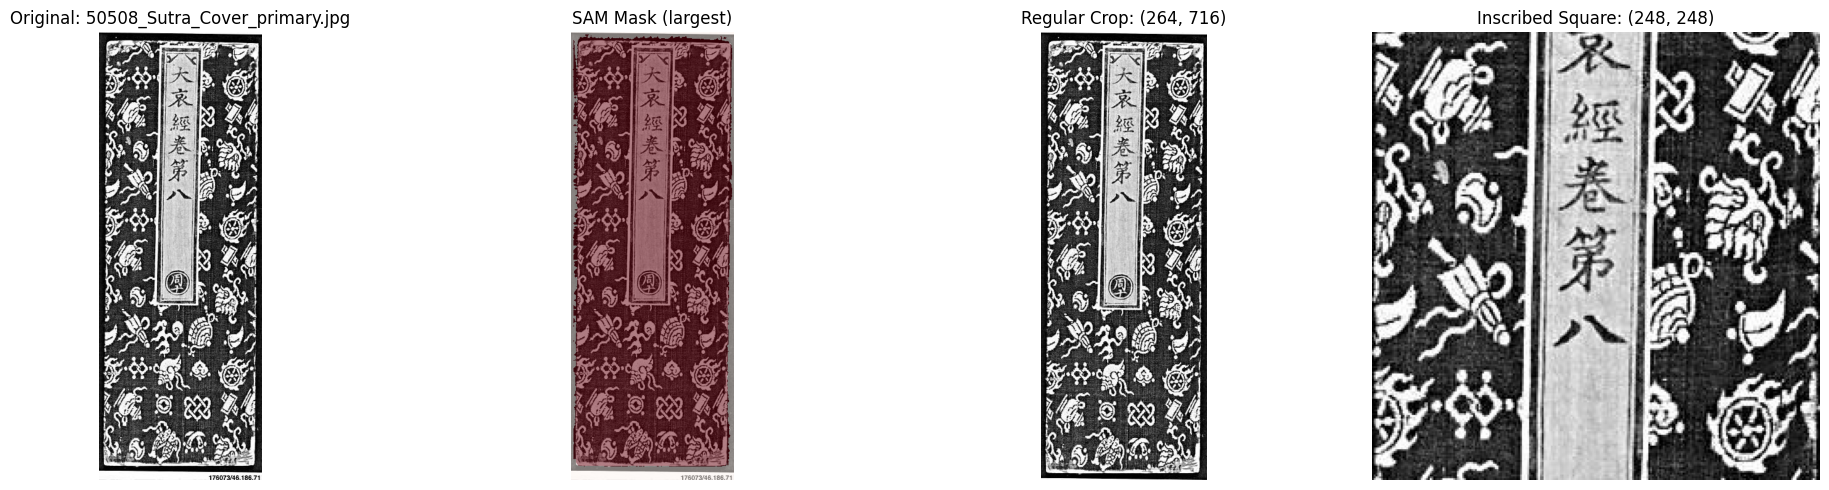

Processing: 153/18645 - 50508_Sutra_Cover_primary.jpg


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import json
import pandas as pd

# New directories for both types of crops and masks
INSCRIBED_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/inscribed_square")
REGULAR_CROP_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/regular_crop")
MASK_DIR = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/masks_png")

INSCRIBED_DIR.mkdir(parents=True, exist_ok=True)
REGULAR_CROP_DIR.mkdir(parents=True, exist_ok=True)
MASK_DIR.mkdir(parents=True, exist_ok=True)

def largest_inscribed_square(mask: np.ndarray):
    """Find the largest square that fits entirely within the True region of the mask."""
    if mask.sum() == 0:
        return None
    
    # Use distance transform to find the largest inscribed square
    from scipy.ndimage import distance_transform_edt
    
    # Distance transform gives distance to nearest False pixel
    dist_transform = distance_transform_edt(mask)
    
    # Find the point with maximum distance (center of largest inscribed circle)
    max_dist = np.max(dist_transform)
    if max_dist == 0:
        return None
    
    # Find center of largest inscribed square
    center_y, center_x = np.unravel_index(np.argmax(dist_transform), dist_transform.shape)
    
    # The side length of the largest inscribed square is 2 * max_dist
    side_length = int(2 * max_dist)
    
    # Calculate square bounds
    half_side = side_length // 2
    x0 = center_x - half_side
    y0 = center_y - half_side
    x1 = x0 + side_length
    y1 = y0 + side_length
    
    return (x0, y0, x1, y1)

def crop_inscribed_square(pil_img: Image.Image, mask: np.ndarray) -> Image.Image:
    """Return the largest square crop that fits entirely within the mask."""
    square_bounds = largest_inscribed_square(mask)
    
    if square_bounds is None:
        # Fallback: center square of original image
        size = min(pil_img.size)
        left = (pil_img.width - size) // 2
        top = (pil_img.height - size) // 2
        return pil_img.crop((left, top, left + size, top + size))
    
    x0, y0, x1, y1 = square_bounds
    return pil_img.crop((x0, y0, x1, y1))

# Save CSV periodically and resume capability
csv_path = Path("/home/user1/Desktop/HAMZA/THESIS/TEXMET/clean_dataset/processing_log.csv")

# Load existing log if available
if csv_path.exists():
    existing_df = pd.read_csv(csv_path)
    processed_files = set(existing_df['filename'].tolist())
    processing_log = existing_df.to_dict('records')
    print(f"📁 Resuming: Found {len(processed_files)} already processed files")
else:
    processed_files = set()
    processing_log = []

def crop_with_mask_only(pil_img: Image.Image, mask: np.ndarray, pad_px: int = 5) -> Image.Image:
    """Return cropped image containing ONLY the masked region (no background)."""
    if mask.sum() == 0:
        return pil_img

    # Create a new image with transparent/white background
    result_img = Image.new('RGB', pil_img.size, (255, 255, 255))  # White background
    
    # Apply mask to original image
    img_array = np.array(pil_img)
    mask_3d = np.stack([mask, mask, mask], axis=2)  # Convert to 3-channel mask
    
    # Keep only masked pixels, rest becomes white
    masked_array = np.where(mask_3d, img_array, 255)
    masked_img = Image.fromarray(masked_array.astype(np.uint8))
    
    # Now crop to bounding box with padding
    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    # Add padding but keep inside bounds
    y0 = max(0, y0 - pad_px)
    x0 = max(0, x0 - pad_px)
    y1 = min(pil_img.height, y1 + pad_px)
    x1 = min(pil_img.width, x1 + pad_px)

    return masked_img.crop((x0, y0, x1, y1))

print(f"➜Processing {len(img_paths):,} images (skipping {len(processed_files)} already done)")

for i, path in enumerate(tqdm(img_paths, desc="Dual Cropping + Masks")):
    # Skip if already processed
    if path.name in processed_files:
        continue
        
    inscribed_path = INSCRIBED_DIR / path.relative_to(SRC_DIR)
    regular_path = REGULAR_CROP_DIR / path.relative_to(SRC_DIR)
    mask_path = MASK_DIR / path.relative_to(SRC_DIR).with_suffix('.png')
    
    inscribed_path.parent.mkdir(parents=True, exist_ok=True)
    regular_path.parent.mkdir(parents=True, exist_ok=True)
    mask_path.parent.mkdir(parents=True, exist_ok=True)

    try:
        img = Image.open(path).convert("RGB")
        original_size = img.size
    except Exception as e:
        print(f"[WARN] Cannot open {path}: {e}")
        continue

    # ---------- run SAM with memory management -------------------------------
    # print(f"\n[INFO] Processing image: {path.name}")
    img_np = np.array(img)
    original_shape = img_np.shape
    # print(f"[INFO] Original shape: {original_shape}")
    
    # Clear GPU cache and resize if needed
    torch.cuda.empty_cache()
    was_resized = False
    max_size = 1024
    
    if max(img_np.shape[:2]) > max_size:
        scale = max_size / max(img_np.shape[:2])
        new_width = int(img_np.shape[1] * scale)
        new_height = int(img_np.shape[0] * scale)
        img_resized = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        img_np = np.array(img_resized)
        was_resized = True
        print(f"[INFO] Resized to: {img_np.shape} (scale: {scale:.3f})")
    
    with torch.no_grad():
        masks = mask_generator.generate(img_np)
    torch.cuda.empty_cache()
    
    # In your main processing loop, replace the mask selection with:
    
    # Replace your cropping lines with:
    if len(masks) == 0:
        print("[WARN] No masks found, using fallback crop.")
        inscribed_crop = img
        regular_crop = img
        main_mask = None
        mask_area = 0
    else:
        # Try the hybrid approach first
        # best_mask_data = get_robust_mask(masks, img_np.shape)
        
        # # Fallback to smart mask if needed
        # if best_mask_data is None:
        #     print("[INFO] No robust mask found, trying smart selection.")
        #     best_mask_data = get_smart_mask(masks, img_np.shape)
        
        # # Final fallback to largest
        # if best_mask_data is None:
        #     print("[INFO] No smart mask found, using largest mask.")
        best_mask_data = max(masks, key=lambda m: m["area"])
        
        main_mask = best_mask_data["segmentation"]
        mask_area = best_mask_data["area"]
        
        if was_resized:
            # Scale mask back to original image size
            mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
            mask_img = mask_img.resize(original_size, Image.Resampling.NEAREST)
            main_mask = np.array(mask_img) > 128
        
        # Use mask as BOUNDARY ONLY - include everything inside
        inscribed_crop = crop_inscribed_square(img, main_mask)
        regular_crop = crop_everything_inside_mask_boundary(img, main_mask, pad_px=10)

    # Log processing details
    log_entry = {
        'filename': path.name,
        'object_id': get_object_id_from_filename(path),
        'original_size': f"{original_size[0]}x{original_size[1]}",
        'was_resized': was_resized,
        'num_masks': len(masks),
        'mask_area': mask_area,
        'inscribed_size': f"{inscribed_crop.size[0]}x{inscribed_crop.size[1]}",
        'regular_size': f"{regular_crop.size[0]}x{regular_crop.size[1]}",
        'status': 'processed'
    }
    processing_log.append(log_entry)

    # optional: drop very small crops
    if MIN_SIDE_AFTER_CROP and (min(inscribed_crop.size) < MIN_SIDE_AFTER_CROP or min(regular_crop.size) < MIN_SIDE_AFTER_CROP):
        print(f"[WARN] Crop too small, skipping.")
        log_entry['status'] = 'skipped_too_small'
        continue

    # Save all three outputs
    inscribed_crop.save(inscribed_path, quality=JPEG_QUALITY)
    regular_crop.save(regular_path, quality=JPEG_QUALITY)
    
    if main_mask is not None:
        mask_img = Image.fromarray((main_mask * 255).astype(np.uint8), mode='L')
        mask_img.save(mask_path)

    # Save CSV every 10 images (robustness)
    if i % 10 == 0:
        df = pd.DataFrame(processing_log)
        df.to_csv(csv_path, index=False)
        
    # Visualize every 10th image or last few images
    if i % 2 == 0 or i >= len(img_paths) - 5:
        clear_output(wait=True)
        
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        # Original image
        axes[0].imshow(img)
        axes[0].set_title(f"Original: {path.name}")
        axes[0].axis('off')
        
        # Mask overlay
        if main_mask is not None:
            axes[1].imshow(img)
            axes[1].imshow(main_mask, alpha=0.5, cmap='Reds')
            axes[1].set_title("SAM Mask (largest)")
        else:
            axes[1].imshow(img)
            axes[1].set_title("No mask found")
        axes[1].axis('off')
        
        # Regular crop
        axes[2].imshow(regular_crop)
        axes[2].set_title(f"Regular Crop: {regular_crop.size}")
        axes[2].axis('off')
        
        # Inscribed square crop
        axes[3].imshow(inscribed_crop)
        axes[3].set_title(f"Inscribed Square: {inscribed_crop.size}")
        axes[3].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Processing: {i+1}/{len(img_paths)} - {path.name}")

# Final save
df = pd.DataFrame(processing_log)
df.to_csv(csv_path, index=False)
print(f"✅ Done. Processing log saved to {csv_path}")
print(f"✅ Total processed: {len(df)}")
print(f"✅ Resized images: {df['was_resized'].sum()}")
print(f"✅ Done. Inscribed squares in {INSCRIBED_DIR}")
print(f"✅ Done. Regular crops in {REGULAR_CROP_DIR}")
print(f"✅ Done. Masks in {MASK_DIR}")